# Deep Deterministic Policy Gradient for Portfolio Management

Steps to try:
1. We first try to overfit a 3 stocks toy case using 3 years of training data.
2. Try to generalize to other years of the same stock.
3. Get some insigts on network topology and hyperparameter tuning.
4. Increase the number of stocks. (Increase action space to more than 10.)

## Setup

In [1]:
import numpy as np
from utils.data import read_stock_history, index_to_date, date_to_index
import matplotlib.pyplot as plt
# for compatible with python 3
from __future__ import print_function
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
%qtconsole

In [2]:
# read the data and choose the target stocks for training a toy example
history, abbreviation = read_stock_history(filepath='utils/datasets/stocks_history_target.h5')
history = history[:, :, :4]
target_stocks = ['AAPL', 'CMCSA', 'REGN']
training_date_start = '2012-08-13'
training_date_end = '2015-08-13'  # three years training data
training_index_start = date_to_index(training_date_start)
training_index_end = date_to_index(training_date_end)
target_history = np.empty(shape=(len(target_stocks), training_index_end - training_index_start, history.shape[2]))
for i, stock in enumerate(target_stocks):
    target_history[i] = history[abbreviation.index(stock), training_index_start:training_index_end, :]

In [15]:
# collect testing data
testing_date_start = '2015-08-13'
testing_date_end = '2017-08-12'
testing_index_start = date_to_index(testing_date_start)
testing_index_end = date_to_index(testing_date_end)
testing_history = np.empty(shape=(len(target_stocks), testing_index_end - testing_index_start, history.shape[2]))
for i, stock in enumerate(target_stocks):
    testing_history[i] = history[abbreviation.index(stock), testing_index_start:testing_index_end, :]

In [16]:
print(target_history.shape)
print(testing_history.shape)

(3, 1095, 4)
(3, 730, 4)


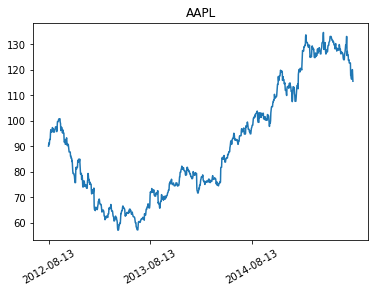

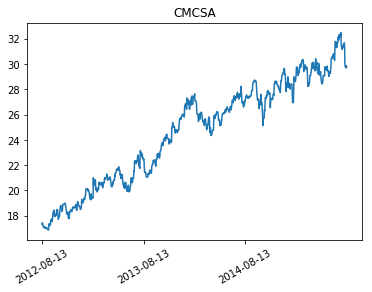

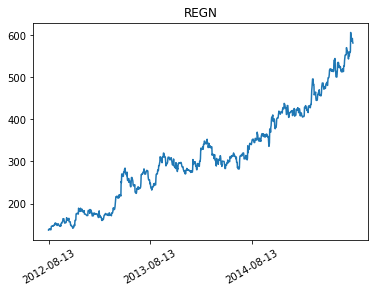

In [4]:
# visualize 3 stock open price
date_list = [index_to_date(i) for i in range(target_history.shape[1])]
x = range(target_history.shape[1])
for i in range(len(target_stocks)):
    plt.figure(i)
    plt.plot(x, target_history[i, :, 1])  # open, high, low, close = [0, 1, 2, 3]
    plt.xticks(x[::365], date_list[::365], rotation=30)
    plt.title(target_stocks[i])
    plt.show()

In [5]:
from environment.portfolio import PortfolioEnv

In [6]:
# instantiate environment, 3 stocks, no trading cost, window_length 50, start_date sample each time
env = PortfolioEnv(target_history, target_stocks, trading_cost=0.0)
from model.ddpg.ddpg import DDPG
# instantiate DDPG model
ddpg_model = DDPG(env=env)

In [ ]:
# starts to train the model, hopefully it would work
ddpg_model.train(verbose=False)

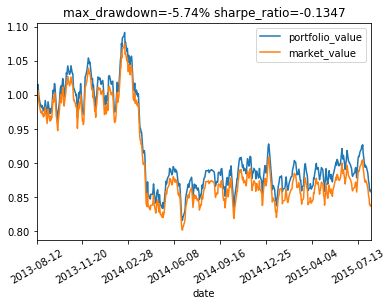

In [14]:
# evaluate the model with training data
env = PortfolioEnv(target_history, target_stocks, trading_cost=0.0)
observation, action = env.reset()
done = False
while not done:
    action = ddpg_model.predict(observation, action)
    action = np.squeeze(action, axis=0)
    observation, _, done, _ = env.step(action)
env._render()

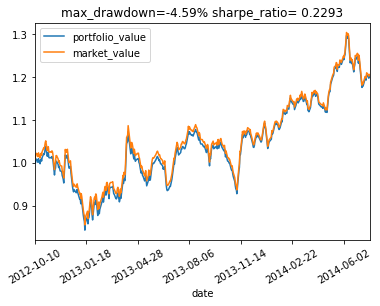

In [21]:
# evaluate the model with unseen data from same stock
env = PortfolioEnv(testing_history, target_stocks, steps=650, trading_cost=0.0)
observation, action = env.reset()
done = False
while not done:
    action = ddpg_model.predict(observation, action)
    action = np.squeeze(action, axis=0)
    observation, _, done, _ = env.step(action)
env._render()